# tests

In [14]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# dengue_df = pd.read_csv('promed_dengue.csv', sep='\t')
# malaria_df = pd.read_csv('promed_malaria.csv')
# chikungunya_df = pd.read_csv('promed_chikungunya.csv', sep='\t')
# zika_df = pd.read_csv('promed_zika.csv', sep='\t')

# dengue_df['disease'] = 'dengue'
# malaria_df['disease'] = 'malaria'
# chikungunya_df['disease'] = 'chikungunya'
# zika_df['disease'] = 'zika'

# combined_df = pd.concat([dengue_df, malaria_df, chikungunya_df, zika_df])
# combined_df = combined_df.reset_index()
# combined_df.to_feather('combined_df_raw.arrow')

In [3]:
combined_df = pd.read_feather('combined_df_raw.feather')

In [22]:
combined_df.zoom_lat.iloc[0], combined_df.zoom_lon.iloc[0]

(23.95046, -102.53289)

In [4]:
gdf = gpd.GeoDataFrame(combined_df, geometry=gpd.points_from_xy(combined_df.zoom_lon, combined_df.zoom_lat))

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


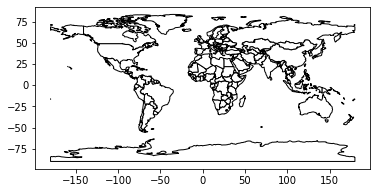

In [7]:
ax = world.plot(color='white', edgecolor='black')

<AxesSubplot:>

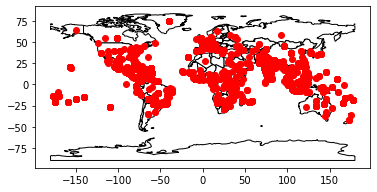

In [17]:
gdf.plot(ax=world.plot(color='white', edgecolor='black'), color='red')

# calculate anomalies

In [22]:
import pandas as pd
import json
from datetime import datetime

In [32]:
disease_df = pd.read_feather('combined_df_raw.feather')

In [41]:
precip_df = pd.read_csv('total_precip.csv')

In [42]:
precip_df['precips'] = precip_df.precips.apply(lambda x: json.loads(x))
precip_df['mean'] = precip_df.precips.apply(lambda x: sum(x)/250)

In [47]:
precip_df.drop('Unnamed: 0', axis=1, inplace=True)

In [122]:
GPM_START_DATE = datetime(2000, 6, 1)
def calculate_anomaly(row):
	article_date = datetime.strptime(row['issue_date'], '%Y-%m-%d %H:%M:%S')
	num_months = (article_date.year - GPM_START_DATE.year) * 12 + (article_date.month - GPM_START_DATE.month)
	precip_data = precip_df.loc[(precip_df['lat_idx'] == row['gpm_lat_idx']) & (precip_df['lon_idx'] == row['gpm_lon_idx'])]
	if num_months >= 250:
		precip_total = precip_data['precips'].values[0][249]
	elif num_months <= 0:
		precip_total = precip_data['precips'].values[0][0]
	else:
		precip_total = precip_data['precips'].values[0][num_months]
	precip_mean = precip_data['mean'].values[0]
	anomaly = (precip_total-precip_mean)/precip_mean
	return anomaly

In [123]:
disease_df['precipitation_anomaly'] = disease_df.apply(calculate_anomaly, axis=1)

In [127]:
disease_df['precipitation_anomaly'].describe()

count    2991.000000
mean        0.101564
std         0.993137
min        -1.000000
25%        -0.598752
50%        -0.004472
75%         0.472081
max        21.515309
Name: precipitation_anomaly, dtype: float64

In [ ]:
disease_df.to_feather('combined_df_anomaly.feather')

# more tests

In [57]:
from datetime import datetime

In [56]:
disease_df.iloc[0]

index                                                               0
Unnamed: 0                                                    8163513
id                                                            8163513
title                            ['Dengue/DHF update (01): Americas']
zoom_lat                                                     23.95046
zoom_lon                                                   -102.53289
zoom_level                                                          5
alert_id                                                      8163513
feed_id                                                             1
summary                     PRO/EDR> Dengue/DHF update (01): Americas
issue_date                                        2021-02-04 06:39:21
load_date                                         2021-02-04 06:39:21
incident_date                                                     NaN
descr               Cases by Country / Week updated / Serotype / T...
alert_tag_id        

In [59]:
date = datetime.strptime(disease_df.iloc[0]['issue_date'], '%Y-%m-%d %H:%M:%S')

In [71]:
START_DATE = datetime(2000, 6, 1)

In [73]:
months = (date.year - START_DATE.year) * 12 + (date.month - START_DATE.month)

In [51]:
disease_df.iloc[0].gpm_lat_idx, disease_df.iloc[0].gpm_lon_idx

(1139, 774)

In [96]:
precip_df.loc[(precip_df['lat_idx'] == 1139) & (precip_df['lon_idx'] == 774)]

,lat_idx,lon_idx,precips,mean
0,1139,774,"[0.1988884, 0.06614161, 0.06951254, 0.04481283...",0.050947


In [100]:
precip_df.loc[(precip_df['lat_idx'] == 1139) & (precip_df['lon_idx'] == 774)]['precips']

0    [0.1988884, 0.06614161, 0.06951254, 0.04481283...
Name: precips, dtype: object